# DLW Practical 3 (extra)
# Any architecture on COLOR

**Introduction**

In this practical, we will apply a linear model to the COLOR data set. The COLOR data set comes as 18 different colour classes (red, green, gold, etc.) consisting of 9x9x3 RGB images. The data will be downloaded automatically in the first cell. Alternatively, the data can be downloaded [here](https://drive.google.com/open?id=1b2zwUWVVwdJkEAavMXv1D9wfjaG0Nf1W).

The challenge is to build a classifier that can correctly classify each of the 18 different colour classes present in the test set. You are welcome to use any network architecture for this exercise. Use a confusion matrix to understand what the model is struggling to classify correctly. What is your best test set accuracy? What network architecture can you use to improve certain colours to get higher classification accuracy?



In [19]:
%matplotlib inline

import os
import time
import datetime
import itertools
import pandas as pd
import pickle as pk
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.python.framework import graph_util
from tensorflow.python.platform import gfile
from tensorflow.python.framework import tensor_shape
from tensorflow.contrib.tensorboard.plugins import projector

if not os.path.isfile('data.pk'):
    os.system('curl -L "https://docs.google.com/uc?export=download&id=1b2zwUWVVwdJkEAavMXv1D9wfjaG0Nf1W" > data.pk')
print("Data downloaded...")

Data downloaded...


In [8]:
##############################################
# open the training, validation and test set #
##############################################

with open('data.pk', 'rb') as handle:
    data = pk.load(handle)

print('\nTraining: {}\nValidation: {}\nTesting: {}\n\nUnique labels: \n{}'.format(data[0].shape, data[1].shape, data[2].shape, data[3]))

col = len(data[0].columns.values) - 3

# one-hot encode the output labels #
train_x, train_y = data[0][list(range(col))].values, pd.get_dummies(data[0]['class_id'].values).as_matrix()
val_x, val_y = data[1][list(range(col))].values, pd.get_dummies(data[1]['class_id'].values).as_matrix()
test_x, test_y = data[2][list(range(col))].values, pd.get_dummies(data[2]['class_id'].values).as_matrix()

train_examples, x_dim, n_classes = train_x.shape[0], train_x.shape[1], train_y.shape[1]

print('\nTraining examples: {}\nInput dimension (flatten): {}\nNumber of classes: {}\n'.format(train_examples, x_dim, n_classes))


Training: (6200, 246)
Validation: (2067, 246)
Testing: (2067, 246)

Unique labels: 
                0
0           black
1   black & white
2            blue
3           brown
4          copper
5            gold
6           green
7            grey
8    multi-colour
9         neutral
10         orange
11           pink
12         purple
13            red
14      rose gold
15         silver
16          white
17         yellow

Training examples: 6200
Input dimension (flatten): 243
Number of classes: 18



In [9]:
##################
# save the model #
##################

def save_model(session, model_name):
    output_graph_def = graph_util.convert_variables_to_constants(session, session.graph.as_graph_def(), ['output_prediction'])
    with gfile.FastGFile(model_name, 'wb') as f:
        f.write(output_graph_def.SerializeToString())

In [10]:
##############
# mini-batch #
##############

def random_mini_batches(X, Y, train_examples, mini_batch_size=64):
    np.random.seed(None)
    m = train_examples
    mini_batches = []

    permutation = list(np.random.permutation(m))

    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]
    num_complete_minibatches = int(np.floor(m / mini_batch_size))

    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size) #
    if m % mini_batch_size != 0:
        a = m - (num_complete_minibatches * mini_batch_size)
        mini_batch_X = shuffled_X[-a:]
        mini_batch_Y = shuffled_Y[-a:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [46]:
################
# linear model #
################

def linear_model(x_dim, n_classes):
    x = tf.placeholder(tf.float32, [None, x_dim], name='input')
    W1 = tf.Variable(tf.random_normal([x_dim, n_classes], stddev=np.sqrt(1. / x_dim)), name='W1')
    b1 = tf.Variable(tf.zeros([n_classes]), name='b1')
    y = tf.add(tf.matmul(x, W1), b1)
    y_ = tf.placeholder(tf.float32, [None, n_classes])
    prediction = tf.nn.softmax(y, name='output_prediction')
    return x, W1, b1, y, y_, prediction, keep_prob, keep_nodes

In [50]:
#########################
# define training cycle #
#########################

seed = None
epochs = 10
minibatch_size = 100
num_minibatches = int(np.ceil(train_examples / minibatch_size))

print('Epochs: {}\nMini-batch size: {}\nNumber of mini-batches: {}\n'.format(epochs, minibatch_size, num_minibatches))

graph = tf.Graph()

with graph.as_default():

    x, W1, b1, y, y_, prediction, keep_prob, keep_nodes = linear_model(x_dim, n_classes)

    #############################
    # define loss/cost function #
    #############################

    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))
    learning_rate = 0.001
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)

    ###########################
    # define model evaluation #
    ###########################

    # returns the index with the largest value across axis of a tensor #
    act_class, pred_class = tf.argmax(y_, 1), tf.argmax(tf.nn.softmax(y), 1)
    correct_prediction = tf.cast(tf.equal(pred_class, act_class), tf.float32)
    classification_accuracy = tf.reduce_mean(correct_prediction)

    labels = tf.argmax(y_, 1)
    top_3 = tf.nn.in_top_k(tf.nn.softmax(y), labels, 3)
    top_3_accuracy = tf.reduce_mean(tf.cast(top_3, tf.float32))

    # launch the graph in a session (use the session as a context manager) #
    with tf.Session() as sess:
        # initializing the variables before starting the session #
        init = tf.global_variables_initializer()
        # run session #
        sess.run(init)
        loss = []
        start_time = time.time()
        # loop every epoch #
        for epoch in range(epochs):
            # average cost per epoch #
            train_avg_cost = 0.
            val_avg_cost = 0.
            # get mini-batches #
            minibatches = random_mini_batches(train_x, train_y, train_examples, minibatch_size)
            total_batch = len(minibatches)
            # loop every mini-batch #
            for minibatch in minibatches:
                # determine batch #
                batch_xs, batch_ys = minibatch
                # calculate validation loss #
                train_cross_ent_loss = sess.run(cross_entropy_loss, feed_dict={x: batch_xs, y_: batch_ys})
                # calculate validation loss #
                val_cross_ent_loss = sess.run(cross_entropy_loss, feed_dict={x: val_x, y_: val_y})
                # execute operations on graph #
                sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
                # average cost per number of mini-batches #
                train_avg_cost += train_cross_ent_loss / total_batch
                val_avg_cost += val_cross_ent_loss / total_batch
                # training and validation accuracy #
                train_class_acc, train_top_3_acc = sess.run([classification_accuracy, top_3_accuracy], feed_dict={x: train_x, y_: train_y})
                val_class_acc, val_top_3_acc = sess.run([classification_accuracy, top_3_accuracy], feed_dict={x: val_x, y_: val_y})

            print('------------------------------------------')
            print('Epoch {0}:\nTraining loss: {1:.3f}\nValidation loss: {2:.3f}\n'.format(epoch, train_avg_cost, val_avg_cost))
            print('Training accuracy:   {0:.2f}% (Top 3: {1:.2f}%)\nValidation accuracy: {2:.2f}% (Top 3: {3:.2f}%)'.format(train_class_acc * 100, train_top_3_acc * 100, val_class_acc * 100, val_top_3_acc * 100))
                
        save_model(sess, 'output_graph.pb')

    print('------------------------------------------')
    print('\nTraining time: {}\n'.format(datetime.timedelta(seconds=time.time() - start_time)))
    data[3][0].to_csv("labels.txt", header=False, index=False)

    ###############################
    # test and evaluate the model #
    ###############################

    # plot_losses(loss, show=True)
    # p_class, a_class, c_acc, t_5 = sess.run([pred_class, act_class, classification_accuracy, top_5_accuracy], feed_dict={x: list(test_x), y_: test_y, keep_prob: 1.0})
    # classify_report(a_class, p_class, data[3][0].values)
    # print('\nClassification accuracy: {0:.2f} (Top 3: {1:.2f})\n'.format(c_acc, t_5))
    # print('\n', classification_report(a_class, p_class, target_names=data[3][0].values))
    # confusion_matrix_plot(a_class, p_class, data[3][0].values, show=True)


Epochs: 25
Mini-batch size: 100
Number of mini-batches: 62

------------------------------------------
Epoch 0:
Training loss: 48.908
Validation loss: 48.510

Training accuracy:   31.52% (Top 3: 59.71%)
Validation accuracy: 31.16% (Top 3: 58.01%)
------------------------------------------
Epoch 1:
Training loss: 22.340
Validation loss: 22.272

Training accuracy:   35.45% (Top 3: 65.90%)
Validation accuracy: 35.66% (Top 3: 65.41%)
------------------------------------------
Epoch 2:
Training loss: 19.569
Validation loss: 19.816

Training accuracy:   36.81% (Top 3: 68.58%)
Validation accuracy: 36.09% (Top 3: 68.26%)
------------------------------------------
Epoch 3:
Training loss: 17.513
Validation loss: 17.703

Training accuracy:   37.06% (Top 3: 66.63%)
Validation accuracy: 34.78% (Top 3: 67.20%)
------------------------------------------
Epoch 4:
Training loss: 17.401
Validation loss: 18.040

Training accuracy:   40.03% (Top 3: 70.31%)
Validation accuracy: 39.04% (Top 3: 68.12%)
-----

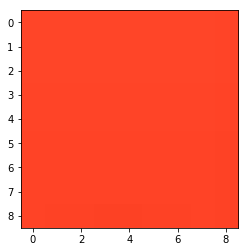


 0
red                      | 1.0000
brown                    | 0.0000
orange                   | 0.0000


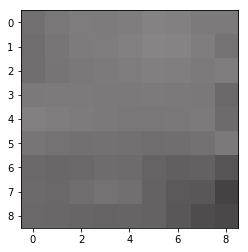


 1
multi-colour             | 0.4811
neutral                  | 0.4534
white                    | 0.0627


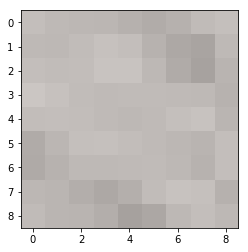


 2
white                    | 0.9999
black & white            | 0.0001
silver                   | 0.0000


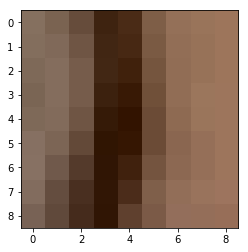


 3
neutral                  | 1.0000
pink                     | 0.0000
rose gold                | 0.0000


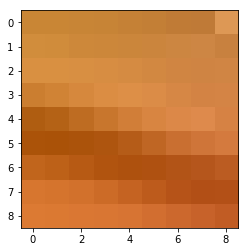


 4
orange                   | 0.8557
brown                    | 0.0988
copper                   | 0.0455


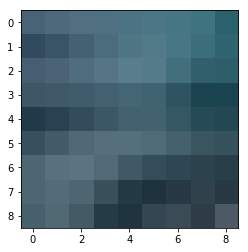


 5
blue                     | 0.8478
black & white            | 0.1520
grey                     | 0.0002


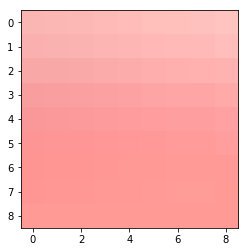


 6
pink                     | 0.9986
rose gold                | 0.0013
brown                    | 0.0001


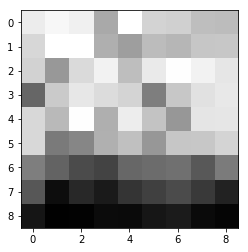


 7
neutral                  | 0.9912
grey                     | 0.0087
multi-colour             | 0.0001


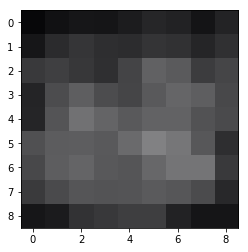


 8
silver                   | 1.0000
black & white            | 0.0000
yellow                   | 0.0000


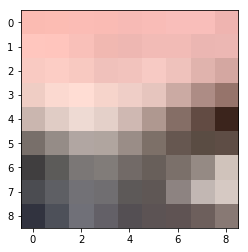


 9
silver                   | 1.0000
pink                     | 0.0000
purple                   | 0.0000


In [52]:
##########################################################
# unpersist tensorflow model and predict test set images #
##########################################################

labels = dict(enumerate(data[0]['class'].cat.categories))
idx = np.random.permutation(500)[:10]

# unpersists tensorflow graph from file #
with tf.gfile.FastGFile('output_graph.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

# initialise tensorflow session #
with tf.Session() as sess:
    # feed the image_data as input to the graph and get first prediction #
    softmax_tensor = sess.graph.get_tensor_by_name('output_prediction:0')
    for i, j in enumerate(idx):
        predictions = sess.run(softmax_tensor, {'input:0': test_x[j].reshape(-1, 243)})
        top_k = predictions[0].argsort()[-len(predictions[0]):][::-1]
        t = np.asarray(test_x[j].reshape(-1, 243), dtype="int32")
        im = Image.fromarray(np.uint8(t.reshape(9, 9, 3)))
        plt.imshow(im)
        plt.show()
        # im.save('tests/{}.jpg'.format(i))

        print('\n', i)
        # print predictions to stdout for now #
        for node_id in top_k[:3]:
            human_string = labels[node_id]
            score = predictions[0][node_id]
            print('{0:24} | {1:.4f}'.format(human_string, score))